# Homework 3: Hyperparameter Tuning with SVMs

The final deliverable for this homework will be this Jupyter notebook, which should include all relevant code, markdown cells before each code block describing what the code does, and any write-ups/images/plots that you wish to include.

To add a block click on `Insert > Insert Cell Below`. To make a markdown cell, click the drop-down menu at the top of this page and select `Markdown`. 

The starter code for this homework is purposely very minimal. You should get used to coding from scratch. Just follow all the instructions in the PDF you will be fine.

In [1]:
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

Importing the data set

In [2]:
names = ["ID", "clump thickness","uniformity of cell size", 
         "uniformity of cell shape", "marginal adhesion", 
         "single epithelial cell size", "bare nuclei", 
         "bland chromatin", "normal nucleoli", "mitoses", "class"]
df = pd.read_csv("breast-cancer-wisconsin.data", names=names)
              

No null/empty data

In [3]:
df.isnull().values.any()

False

Drop ID variable since it is not useful for our visualization and machine learning

In [4]:
df = df.drop("ID", axis=1)

## Normalize Data

Basic normalization using $$Z = \frac{X-\mu}{\sigma}$$

In [5]:
for feature in names[1:-1]:
    df[feature] = (df[feature] - df[feature].mean())/df[feature].std()

## Replace Class

In [6]:
df["class"] = df["class"].replace(to_replace={2:0, 4:1})

## Data Visualization

Comparing in 1D, we can see that class 4 (malignant) has somewhat higher measurements in almost all features as compared to class 2 (benign). Hence, it seems that we can use SVM to split the dataset by classes. The means are in diamond shapes.

<a id='data'></a>

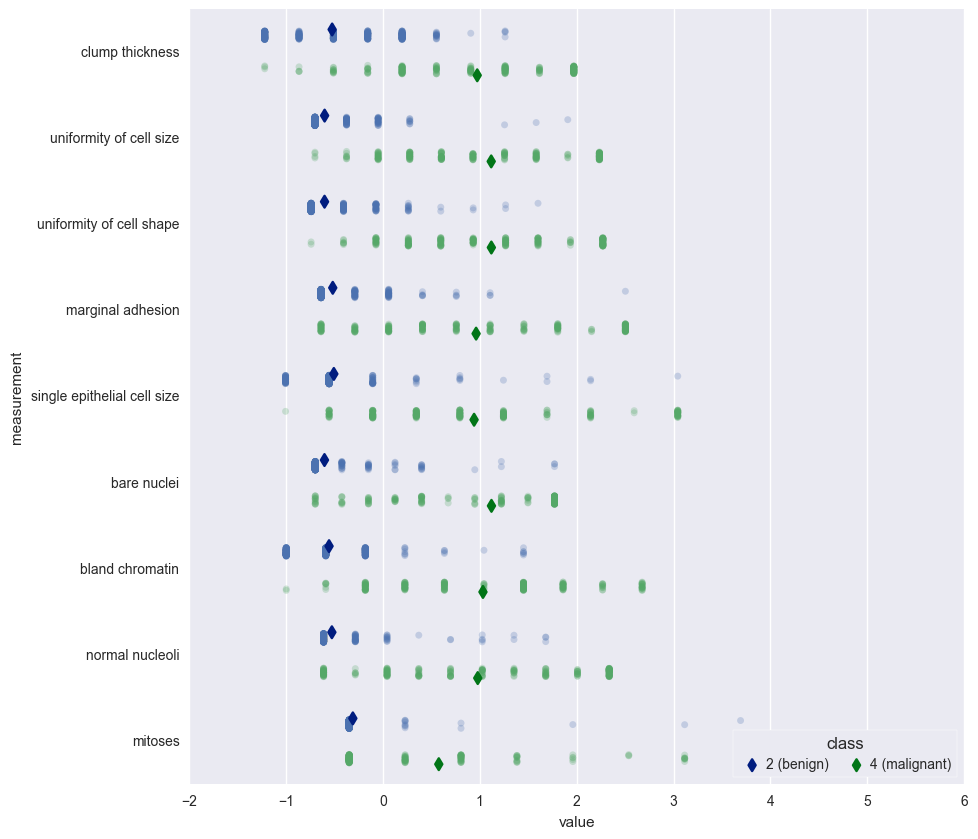

In [7]:
visual_df = pd.melt(df, "class", var_name="measurement")
# initialize figure
f, ax = plt.subplots(figsize=(10,10))
sns.despine(bottom=True, left=True)
# show each observation with scatterplot
sns.stripplot(x="value", y="measurement", hue="class", data=visual_df,
              dodge=True, jitter=True, alpha=.25, zorder=1)
# show means based on class
sns.pointplot(x="value", y="measurement", hue="class", data=visual_df, 
              dodge=.532, join=False, palette="dark", markers="d", 
              scale=.75, ci=None)
# improve legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], ["2 (benign)", "4 (malignant)"], title="class",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)

## SVC

### Polynomial Kernel

Hyperparameter tuning

In [8]:
Cs = [.0001, .001, .01, .1, 1, 10, 100]
ds = [1, 2, 3, 4, 5]
X_train, X_test, y_train, y_test = train_test_split(
                                   df[names[1:-1]], df["class"],
                                   test_size = .3)
accuracies = np.ndarray(shape=(len(Cs), len(ds)))

for i, C in enumerate(Cs):
    for j, degree in enumerate(ds):
        svc = SVC(kernel='poly', degree=degree, C=C)
        svc.fit(X_train, y_train)
        accuracies[i, j] = svc.score(X_train, y_train)

It seems degree = 3 and C = 1 has the best accuracy.

Highest accuracy at C = 10.00 and degree = 3.00 with maximum accuracy of 0.987448


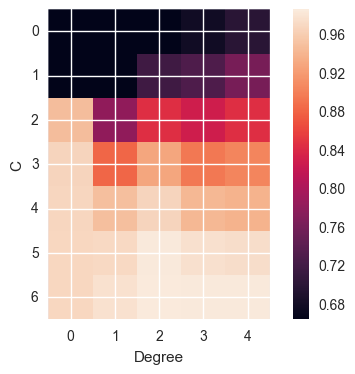

In [9]:
plt.imshow(accuracies, interpolation='none')
plt.xlabel('Degree')
plt.ylabel('C')
plt.colorbar()
max_indices = np.argmax(accuracies)
print("Highest accuracy at C = %.2f and degree = %.2f"
      %(Cs[max_indices//len(ds)], ds[max_indices%len(ds)]),
      end=" ")
print("with maximum accuracy of %f"%np.amax(accuracies))

Retrain data with the C = 100 and degree = 3 and compute accuracy for test data. It is found that the accuracy in the test data is lower, showing signs of overfitting in our SVM classifier. Nevertheless, the accuracy score is still pretty high.

In [10]:
svc = SVC(kernel='poly', C=100, degree=3)
svc.fit(X_train, y_train)
print("Accuracy on training set: %f"%svc.score(X_train, y_train))
print("Accuracy on test set: %f"%svc.score(X_test, y_test))

Accuracy on training set: 0.987448
Accuracy on test set: 0.951220


### Bonus Problem


In [11]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[122   4]
 [  6  73]]


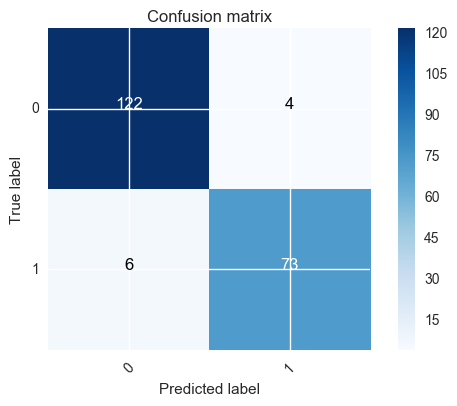

In [12]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, svc.predict(X_test))
plot_confusion_matrix(mat, classes = [0, 1])

### Radial Basis Function Kernel

Hyperparameter tuning using GridSearchCV

In [13]:
Cs = [.0001, .001, .01, .1, 1, 10, 100]
gammas = [.001, .01, .1, 1, 10, 100]
params = {'C': Cs, 'gamma': gammas}
svc = SVC(kernel='rbf')
clf = GridSearchCV(estimator=svc, param_grid=params)
clf.fit(X_train, y_train)
print("Highest accuracy at C = %.2f and gamma = %.2f"
      %(clf.best_estimator_.C, clf.best_estimator_.gamma),
      end=" ")
print("with maximum accuracy of %f"%clf.best_score_)

Highest accuracy at C = 1.00 and gamma = 0.01 with maximum accuracy of 0.968619


## Conclusion

Why are SVMs a better model choice?

As visualized [earlier](#data), it seems pretty easy to seperate the classes based on their values in each features.